In [1]:
from general_tools.notebook import gpu_utils
GPU = 0
gpu_utils.setup_one_gpu(GPU)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean
from sklearn.manifold import TSNE

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.in_out.basics import read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.data_sets.model_net import pc_loader, classes_to_integers
from tf_lab.nips.helper import center_pclouds_in_unit_sphere, \
average_per_class, pclouds_with_zero_mean_in_unit_sphere

from sklearn.svm import LinearSVC
from general_tools.simpletons import sort_dict_by_key, sort_dict_by_val

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
put_in_usphere = True
model_net = '40'

In [5]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/all_snc/'
experiment_name = 'no_conv_deeper_snc_rotated2048pts_emd'

In [6]:
train_dir = osp.join(top_data_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))

if conf.train_dir != train_dir: # added to address moving training-folder to other location
    conf.train_dir = train_dir
    conf.save(osp.join(conf.train_dir, 'configuration'))

print conf
conf.n_output = conf.n_input
conf.allow_gpu_growth = True

              allow_gpu_growth: False
                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm': True, 'layer_sizes': [1024, 2048, 6144]}
                       encoder: encoder_with_convs_and_symmetry_new
                  encoder_args: {'filter_sizes': [1, 1, 1, 1], 'n_filters': [128, 128, 256, 512], 'b_norm': True, 'strides': [1, 1, 1, 1]}
               experiment_name: no_conv_deeper_snc_rotated2048pts_emd
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     trai

In [143]:
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]
last_epoch = 1100
ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1100.


In [144]:
model_net_dir = '/orions4-zfs/projects/optas/DATA/Point_Clouds/Model_Net_' + model_net +  '/from_manifold/'
model_net_dir = osp.join(model_net_dir, str(n_pc_samples))

search_pattern = '(.*)train(.*)\.ply$'
train_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

search_pattern = '(.*)test(.*)\.ply$'
test_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

In [145]:
verbose = True
n_threads = 20

pc, model_names, labels = load_point_clouds_from_filenames(train_pc_files, n_threads, pc_loader, verbose)

if put_in_usphere:
    pc = pclouds_with_zero_mean_in_unit_sphere(pc)
train_data = PointCloudDataSet(pc, labels=labels)

pc_, model_names_, labels_ = load_point_clouds_from_filenames(test_pc_files, n_threads, pc_loader, verbose)

if put_in_usphere:
    pc_ = pclouds_with_zero_mean_in_unit_sphere(pc_)
test_data = PointCloudDataSet(pc_, labels=labels_)

9843 pclouds were loaded. They belong in 40 shape-classes.
2468 pclouds were loaded. They belong in 40 shape-classes.


In [146]:
train_feed, train_latent, train_classes = ae.embedding_at_tensor(train_data, conf, tensor_name='bottleneck')
cids = classes_to_integers(int(model_net), train_classes)[1]

test_feed, test_latent, test_classes = ae.embedding_at_tensor(test_data, conf, tensor_name='bottleneck')
cids_ = classes_to_integers(int(model_net), test_classes)[1]

In [16]:
# intercept_scaling_space = [0.1, 0.2, 0.4, 0.5, 1, 2, 3, 4]
# dual_space = [False, True]
# loss_space = ['hinge', 'squared_hinge']
# # c_space = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50]
# c_space = [0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.15]
# all_scores = dict()

# (0.05, 3, True, 'squared_hinge'), 0.84083720930232564

# c_space = [0.05]
# intercept_scaling_space = [3]
# dual_space = [False]
# loss_space = ['squared_hinge']

for c in c_space:
    for intercept in intercept_scaling_space:
        for dual in dual_space:
            for loss in loss_space:
                try:
                    lsvc = LinearSVC(C=c, loss=loss, intercept_scaling=intercept, dual=dual)
                    lsvc.fit(train_latent, cids)

                    print c, intercept, dual, loss
                    score = average_per_class(lsvc, test_latent, cids_)                

                    print score
                    all_scores[(c, intercept, dual, loss)] = score
                except:
                    continue

0.01 0.1 False squared_hinge
0.819005813953
0.01 0.1 True hinge
0.79101744186
0.01 0.1 True squared_hinge
0.816505813953
0.01 0.2 False squared_hinge
0.819005813953
0.01 0.2 True hinge
0.795098837209
0.01 0.2 True squared_hinge
0.819755813953
0.01 0.4 False squared_hinge
0.819005813953
0.01 0.4 True hinge
0.795308139535
0.01 0.4 True squared_hinge
0.821255813953
0.01 0.5 False squared_hinge
0.819005813953
0.01 0.5 True hinge
0.795558139535
0.01 0.5 True squared_hinge
0.818005813953
0.01 1 False squared_hinge
0.819005813953
0.01 1 True hinge
0.794389534884
0.01 1 True squared_hinge
0.821755813953
0.01 2 False squared_hinge
0.819005813953
0.01 2 True hinge
0.791476744186
0.01 2 True squared_hinge
0.823005813953
0.01 3 False squared_hinge
0.818465116279
0.01 3 True hinge
0.792308139535
0.01 3 True squared_hinge
0.818465116279
0.01 4 False squared_hinge
0.819005813953
0.01 4 True hinge
0.79226744186
0.01 4 True squared_hinge
0.820215116279
0.02 0.1 False squared_hinge
0.823546511628
0.02 0

In [19]:
best_responses = sort_dict_by_val(all_scores, reverse=True)
best_responses

[((0.08, 0.2, True, 'squared_hinge'), 0.8357151162790698),
 ((0.09, 1, False, 'squared_hinge'), 0.83445930232558152),
 ((0.09, 0.4, False, 'squared_hinge'), 0.8344593023255813),
 ((0.09, 3, False, 'squared_hinge'), 0.8344593023255813),
 ((0.1, 1, False, 'squared_hinge'), 0.8344593023255813),
 ((0.1, 0.2, False, 'squared_hinge'), 0.8344593023255813),
 ((0.09, 0.2, False, 'squared_hinge'), 0.83441860465116269),
 ((0.09, 4, False, 'squared_hinge'), 0.83441860465116269),
 ((0.1, 0.1, False, 'squared_hinge'), 0.83420930232558133),
 ((0.09, 0.1, False, 'squared_hinge'), 0.83416860465116294),
 ((0.1, 2, False, 'squared_hinge'), 0.83416860465116272),
 ((0.1, 0.4, False, 'squared_hinge'), 0.83416860465116272),
 ((0.1, 0.5, False, 'squared_hinge'), 0.83416860465116272),
 ((0.09, 2, False, 'squared_hinge'), 0.83416860465116272),
 ((0.07, 4, False, 'squared_hinge'), 0.83395930232558135),
 ((0.07, 2, False, 'squared_hinge'), 0.83391860465116285),
 ((0.1, 3, False, 'squared_hinge'), 0.83391860465116

In [38]:
# n_train = len(train_latent)
# rids = np.arange(n_train)
# np.random.shuffle(rids)
# train_latent_2 = train_latent[rids]

In [149]:
rank = 2
c, intercept, dual, loss = best_responses[rank][0]
rs = np.random.get_state()
np.random.set_state(rs)
lsvc = LinearSVC(C=c, loss=loss, intercept_scaling=intercept, dual=dual, tol=1e-4)
lsvc.fit(train_latent, cids)
print c, intercept, dual, loss
print lsvc.n_iter_
score = average_per_class(lsvc, test_latent, cids_)
print score

0.09 0.4 False squared_hinge
83
0.837005813953


0.09 1 False squared_hinge


0.837215116279


In [57]:
for i in range(20):
    c, intercept, dual, loss = best_responses[1][0]
    print c, intercept, dual, loss
    lsvc = LinearSVC(C=c, loss=loss, intercept_scaling=intercept, dual=dual, tol=1e5, verbose=True)
    lsvc.fit(train_latent, cids)
    score = average_per_class(lsvc, test_latent, cids_)                
    print score

0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge
[LibLinear]0.025
0.09 1 False squared_hinge


KeyboardInterrupt: 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


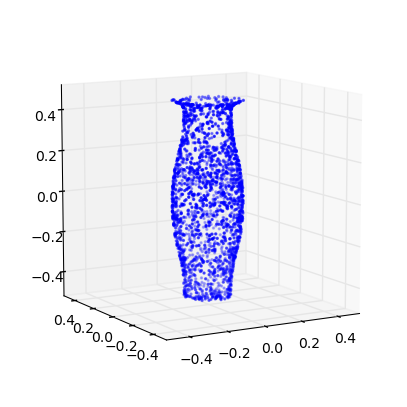

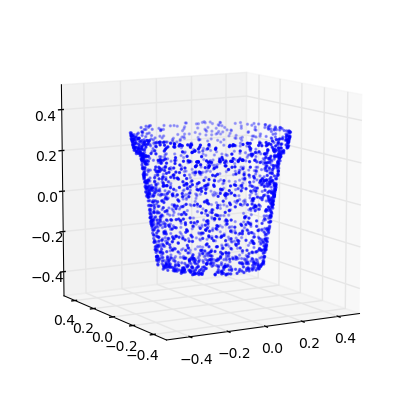

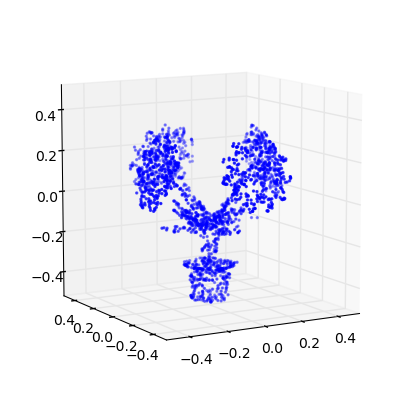

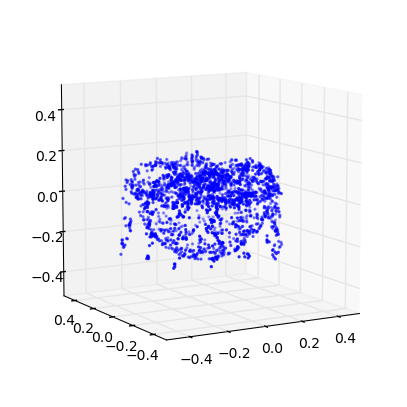

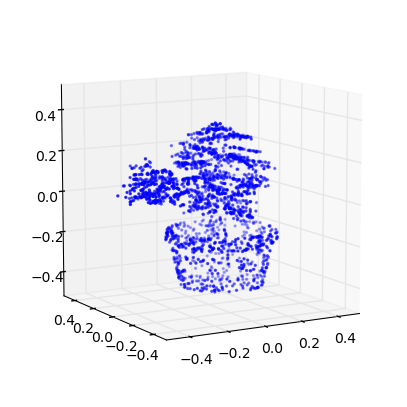

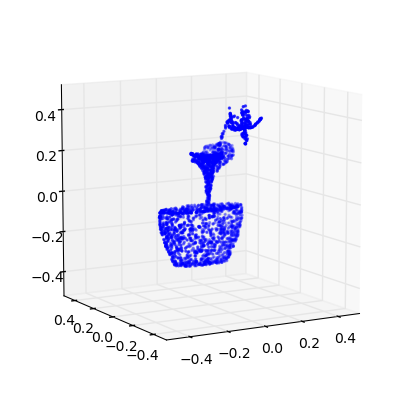

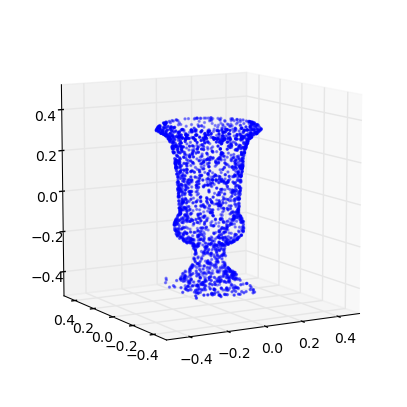

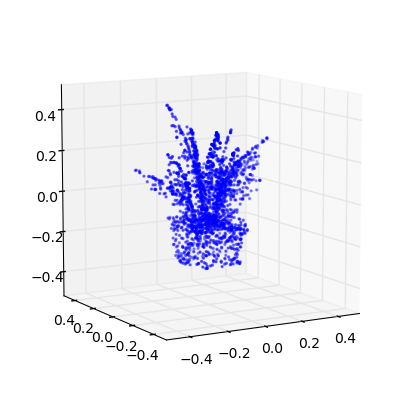

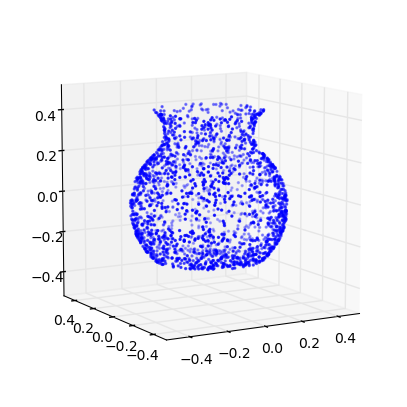

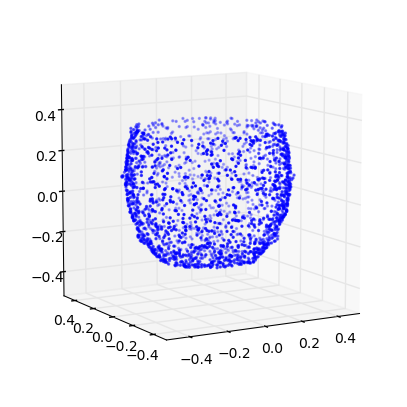

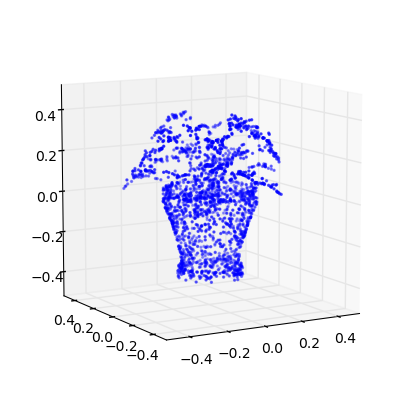

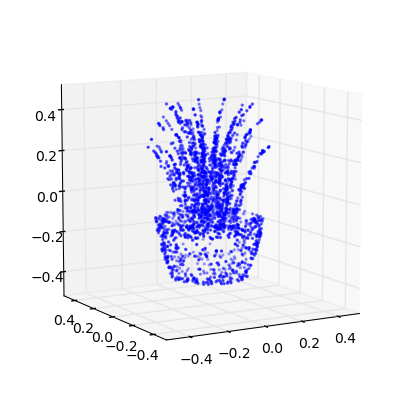

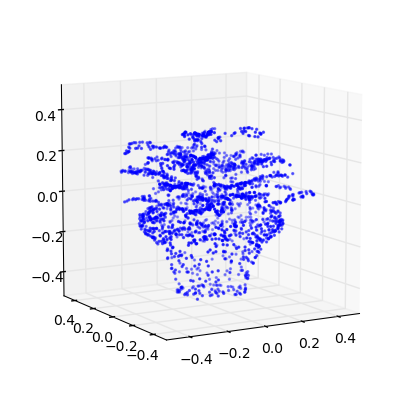

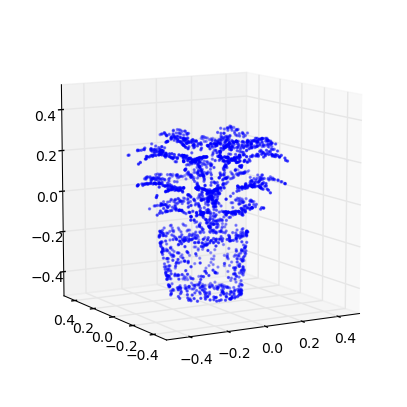

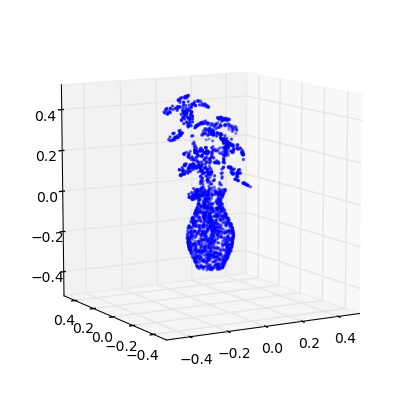

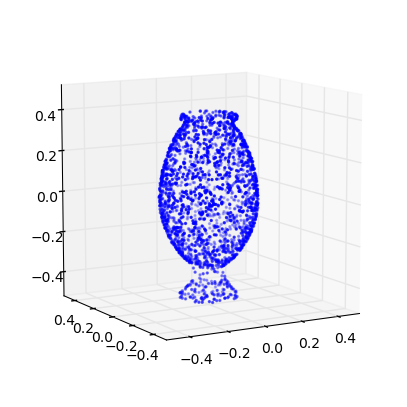

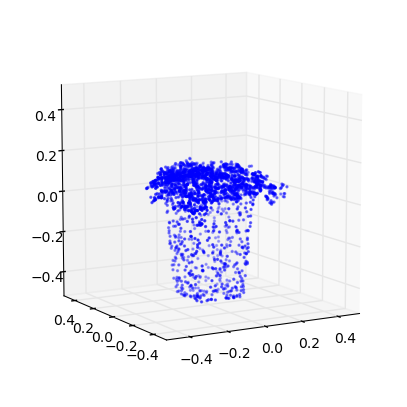

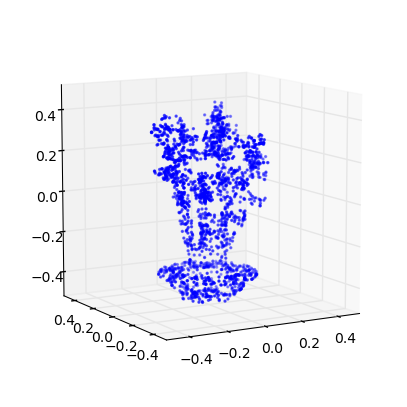

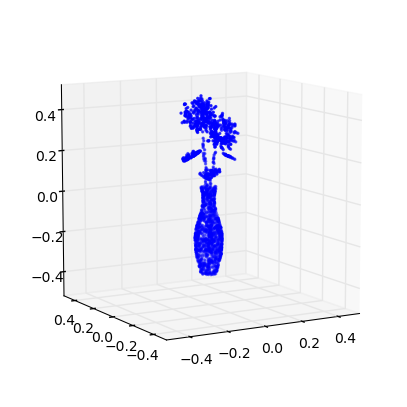

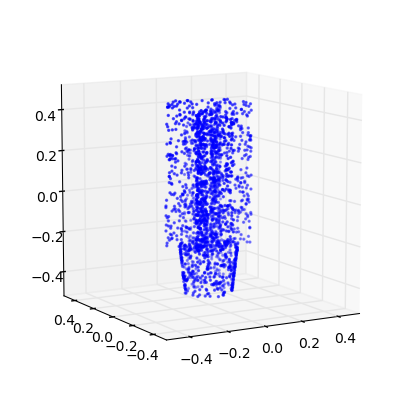

0.832877906977


In [12]:
all_flower_pots = test_feed[np.array(cids_) == 15]
for i in range(len(all_flower_pots)):
    Point_Cloud(all_flower_pots[i]).plot()
    
y_pred = lsvc.predict(test_latent)
gt_labels = np.array(cids_)

scores_per_class = []

for c in np.unique(gt_labels):
    if c == 15:
        scores_per_class.append(0.5)    
        continue
    index_c = gt_labels == c
    n_class = float(np.sum(index_c))
    s = np.sum(gt_labels[index_c] == y_pred[index_c])
    s /= n_class
    scores_per_class.append(s)
print np.mean(scores_per_class)

[((0.25, 0.5, False, 'squared_hinge'), 0.84268635250918),
 ((0.25, 0.1, False, 'squared_hinge'), 0.84268635250918),
 ((0.15, 4, True, 'squared_hinge'), 0.84254283965728261),
 ((0.25, 2, False, 'squared_hinge'), 0.84243635250917992),
 ((0.25, 1, False, 'squared_hinge'), 0.84243635250917992),
 ((0.25, 0.4, False, 'squared_hinge'), 0.84243635250917992),
 ((0.25, 4, False, 'squared_hinge'), 0.84243635250917992),
 ((0.25, 0.2, False, 'squared_hinge'), 0.84243635250917992),
 ((0.25, 3, False, 'squared_hinge'), 0.84243635250917992),
 ((0.35, 0.1, False, 'squared_hinge'), 0.84238984088127289),
 ((0.15, 4, False, 'squared_hinge'), 0.84213984088127314),
 ((0.35, 0.2, False, 'squared_hinge'), 0.84213984088127292),
 ((0.35, 4, False, 'squared_hinge'), 0.84213984088127292),
 ((0.35, 0.4, False, 'squared_hinge'), 0.84213984088127292),
 ((0.35, 3, False, 'squared_hinge'), 0.84213984088127292),
 ((0.15, 0.4, False, 'squared_hinge'), 0.84213984088127292),
 ((0.1, 0.4, True, 'squared_hinge'), 0.84192074

In [ ]:

# NIPS - CONV
# experiment_name = 'all_snc_rotated_conv_arch_2048pts_chamfer'
# top_data_dir = '/scr/optas/DATA/nips/nn_models/vanilla_ae/'

# no_bnorm - deep- not wide (new architecture)
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/nn_models/all_snc'
experiment_name ='all_snc_rotated_deeper_mlp_arch_1_pc2048pts_chamfer'
# - it requires c approx 100

# bnorm on encoder - deep- not wide (old architecture)
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/nn_models/all_snc/'
experiment_name ='all_snc_rotated_deeper_mlp_arch_1_pc_bnorm_on_encoder_old_code2048pts_chamfer'
# - >  seems to work with both big and small c

# no bnorm - deep- and wide (new architecture)
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/nn_models/all_snc/'
experiment_name = 'all_snc_rotated_deeper_wider_mlp_arch_1_pc2048pts_chamfer'
# 2K epochs (200, 0.2, True, 'squared_hinge'), 0.7947793757649938),
# 1Kepochs [((80, 2, True, 'squared_hinge'), 0.79456640146878821),


# no bnorm  - deep- not wide (old architecture)
# top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/nn_models/all_snc/'
# experiment_name = 'all_snc_rotated_deeper_mlp_arch_1_pc_no_bnorm_old_code2048pts_chamfer'
# > epoch 600smething was around 81.
# > epoch 850 (40, 2, True, 'squared_hinge'), 0.80518268053855557)



In [ ]:
# New stuff for ICLR
# 1.  Chamfer
# encoder_args: {'filter_sizes': [1, 1, 1, 1, 1], 'strides': [1, 1, 1, 1, 1], 'n_filters': [64, 128, 128, 256, 512], 'dropout_prob': [0, 0, 0, 0, 0.5], 'b_norm': True}
# decoder_args: {'b_norm': True, 'layer_sizes': [512, 1024, 6144]}
# -> @ 980 epochs of training: best was on model-net40:
# 0.6 1 True hinge
# 0.840083537332
# -> @ 1620 epochs of training: best was on model-net40:
# 0.4 1 False squared_hinge
# 0.843783353733
# at @ 2000 epochs of training: best was on model-net40:
# (0.3, 0.2, False, 'squared_hinge'), 0.84087423500612002)


In [ ]:
# FROM NIPS
# USING ALL ShapeNetCore DATA : ~57K models.
# Training at (max) 2K epochs.

# EMD, 2K, model_net_40
# 1.0 3 False squared_hinge
# 0.844814259486
# 1.0 3 True squared_hinge
# 0.844814259486

# EMD, 2K, model_net_10
# 0.4 2 True hinge
# 0.953279069767


# Chamfer, 2K model_net_40
# 0.3 4 False squared_hinge
# 0.856074051408
# 0.3 4 True squared_hinge
# 0.856074051408
# 0.6 1 False squared_hinge
# 0.856264075887
# 0.3 4 False squared_hinge
# 0.856074051408
# 0.6 1 False squared_hinge
# 0.856264075887
# 0.6 1 True squared_hinge
# 0.856264075887
# 0.7 1 False squared_hinge
# 0.856764075887

# Chamfer, 2K model_net_10
# 0.9 4 True hinge
# 0.950790697674
# 0.950790697674
# 0.8 0.5 False squared_hinge

# 1.0 4 True hinge
# 0.950790697674
# 1.0 3 True hinge
# 0.950790697674
# 0.9 4 True hinge
# 0.950790697674

# 0.7 4 True hinge
# 0.950790697674


# With WU 7 Classes:

# M10, CD, 2K epochs
# 0.4 4 True hinge
# 0.95176744186

# M40, CD, 2K epochs
# 1.0 1 True hinge
# 0.84410495716

# M10, EMD, ~2.5K epochs
# about 0.94

# M40, EMD, ~2.5K epochs
# about 0.83